In [190]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
plt.style.use('ggplot')

# Pre-Processing Data Train

In [191]:
df_train = pd.read_csv("tahap-penyisihan-oq-dataquestua/train.csv")

In [192]:
df_train.shape

(341880, 20)

In [193]:
df_train.head()

,datetime,datetime_iso,time-zone,temp,visibility,d_point,feels,min_temp,max_temp,prssr,sea_level,grnd_level,hum,wind_spd,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,clouds
0,283996800,1979-01-01 00:00:00+00:00,28800,24.75 Celcius,NaN,23.89 C,25.76 C,24.28,25.22°C,1012,undetermined,NaN,95,0.82,320.0 °,zero,0,NaN,NaN,100
1,284000400,1979-01-01 01:00:00+00:00,28800,24.58 C,NaN,23.73 C,25.57 C,23.99 C,25.26 C,1012,NaN,NaN,95,0.96 m/s,338.0°,0,0,0,0,100
2,284004000,1979-01-01 02:00:00+00:00,28800,26.6 Celcius,unidentified,24.06 C,26.6 C,26.1 C,27.39,1012,NaN,undetermined,86,1.22 m/s,339.0°,0,volume:zero,NaN,NaN,99
3,284007600,1979-01-01 03:00:00+00:00,28800,27.31 Celcius,NaN,24.37 C,30.9 C,26.59,28.36 C,1012,NaN,undetermined,84,1.08 m/s,342,0.13,nol,0,NaN,94
4,284011200,1979-01-01 04:00:00+00:00,28800,27.41,NaN,25.05 C,31.54 C,26.58 C,28.31 °C,1011,NaN,undetermined,87,0.86,336.0°,0.34,nol,NaN,0,100


In [194]:
df_train.columns

Index(['datetime', 'datetime_iso', 'time-zone', 'temp', 'visibility',
       'd_point', 'feels', 'min_temp', 'max_temp', 'prssr', 'sea_level',
       'grnd_level', 'hum', 'wind_spd', 'wind_deg', 'rain_1h', 'rain_3h',
       'snow_1h', 'snow_3h', 'clouds'],
      dtype='object')

In [195]:
#Membuang kolom dengan informasi serupa (datetime, timezone)
df_train = df_train[['datetime_iso', 'temp', 'visibility',
       'd_point', 'feels', 'min_temp', 'max_temp', 'prssr', 'sea_level',
       'grnd_level', 'hum', 'wind_spd', 'wind_deg', 'rain_1h', 'rain_3h',
       'snow_1h', 'snow_3h', 'clouds']].copy()

In [196]:
df_train.dtypes

datetime_iso    object
temp            object
visibility      object
d_point         object
feels           object
min_temp        object
max_temp        object
prssr           object
sea_level       object
grnd_level      object
hum             object
wind_spd        object
wind_deg        object
rain_1h         object
rain_3h         object
snow_1h         object
snow_3h         object
clouds          object
dtype: object

In [197]:
columns_to_extract = ['temp', 'visibility',
       'd_point', 'feels', 'min_temp', 'max_temp', 'prssr', 'sea_level',
       'grnd_level', 'hum', 'wind_spd', 'wind_deg', 'rain_1h', 'rain_3h',
       'snow_1h', 'snow_3h', 'clouds']

#Menghapus satuan berupa string sekaligus mengubah nilai berupa string menjadi NaN
for column in columns_to_extract:
   df_train[column] = df_train[column].str.extract('(\d+\.\d+|\d+)')

#Mengubah tipe data selain datetime_iso menjadi float
for column in columns_to_extract:
   df_train[column] = df_train[column].astype(float)

#Mengubah tipe data datetime_iso menjadi datetime
df_train['datetime_iso'] = pd.to_datetime(df_train['datetime_iso'])


In [198]:
df_train.dtypes

datetime_iso    datetime64[ns, UTC]
temp                        float64
visibility                  float64
d_point                     float64
feels                       float64
min_temp                    float64
max_temp                    float64
prssr                       float64
sea_level                   float64
grnd_level                  float64
hum                         float64
wind_spd                    float64
wind_deg                    float64
rain_1h                     float64
rain_3h                     float64
snow_1h                     float64
snow_3h                     float64
clouds                      float64
dtype: object

In [199]:
df_train.isna().sum()

datetime_iso         0
temp                 0
visibility      320499
d_point              0
feels                0
min_temp             0
max_temp             0
prssr                0
sea_level       336990
grnd_level      336369
hum                  0
wind_spd             0
wind_deg             0
rain_1h          26598
rain_3h         186654
snow_1h         175398
snow_3h         178868
clouds               0
dtype: int64

In [200]:
#Membuang kolom yang banyak mengandung NaN kecuali rain_1h
df_train = df_train[['datetime_iso', 'temp', 'd_point', 'feels', 
            'min_temp', 'max_temp', 'prssr', 
            'hum', 'wind_spd', 'wind_deg', 'rain_1h', 'clouds']].copy()

#Mengganti nilai NaN pada kolom rain_1h dengan rata-ratanya
df_train['rain_1h'].fillna(df_train['rain_1h'].mean(), inplace=True)

In [201]:
df_train.isna().sum()

datetime_iso    0
temp            0
d_point         0
feels           0
min_temp        0
max_temp        0
prssr           0
hum             0
wind_spd        0
wind_deg        0
rain_1h         0
clouds          0
dtype: int64

In [202]:
df_train.head()

,datetime_iso,temp,d_point,feels,min_temp,max_temp,prssr,hum,wind_spd,wind_deg,rain_1h,clouds
0,1979-01-01 00:00:00+00:00,24.75,23.89,25.76,24.28,25.22,1012.0,95.0,0.82,320.0,0.401359,100.0
1,1979-01-01 01:00:00+00:00,24.58,23.73,25.57,23.99,25.26,1012.0,95.0,0.96,338.0,0.000000,100.0
2,1979-01-01 02:00:00+00:00,26.60,24.06,26.60,26.10,27.39,1012.0,86.0,1.22,339.0,0.000000,99.0
3,1979-01-01 03:00:00+00:00,27.31,24.37,30.90,26.59,28.36,1012.0,84.0,1.08,342.0,0.130000,94.0
4,1979-01-01 04:00:00+00:00,27.41,25.05,31.54,26.58,28.31,1011.0,87.0,0.86,336.0,0.340000,100.0


In [28]:
#Mengekspor data train yang telah di pre-processed
df_train.to_csv('train_Datacraft.csv', index=False)  # index=False untuk menghindari penulisan indeks ke dalam file

# Pre-Processing Data Test

In [203]:
df_test = pd.read_csv("tahap-penyisihan-oq-dataquestua/test.csv")

In [204]:
df_test.shape

(49368, 19)

In [205]:
df_test.head()

,datetime,datetime_iso,time-zone,temp,visibility,d_point,feels,min_temp,max_temp,prssr,sea_level,grnd_level,hum,wind_spd,wind_deg,rain_3h,snow_1h,snow_3h,clouds
0,1514764800,2018-01-01 00:00:00+00:00,28800,26.59 °C,NaN,23.66,26.59,26.02,27.16,1009,NaN,undetermined,84,1.45 m/s,355,0,NaN,no_snow,97
1,1514768400,2018-01-01 01:00:00+00:00,28800,26.51 C,NaN,24.92,26.51 °C,26.06,28.04,1009,NaN,undetermined,91,1.67 m/s,351,0mm,no-snow,0 milimeter,95
2,1514772000,2018-01-01 02:00:00+00:00,28800,28.68 C,NaN,25.71,34.68,28.03 C,29.3 C,1009.0 hPa.,NaN,NaN,84,1.72 m/s,345.0°,0 mm,volume:zero,0,90
3,1514775600,2018-01-01 03:00:00+00:00,28800,28.84 C,NaN,25.25,34.51,28.52,29.08 °C,1008,NaN,NaN,81,1.49,339.0°,0 milimeter,0,NaN,91
4,1514779200,2018-01-01 04:00:00+00:00,28800,29.75 Celcius,,24.62,35.38,29.31 C,30.57,1007,undetermined,undetermined,74,1.39 m/s,339.0°,NaN,0,volume:0,96


In [206]:
df_test.columns

Index(['datetime', 'datetime_iso', 'time-zone', 'temp', 'visibility',
       'd_point', 'feels', 'min_temp', 'max_temp', 'prssr', 'sea_level',
       'grnd_level', 'hum', 'wind_spd', 'wind_deg', 'rain_3h', 'snow_1h',
       'snow_3h', 'clouds'],
      dtype='object')

In [207]:
#Membuang kolom dengan informasi serupa (datetime, timezone)
df_test = df_test[['datetime_iso', 'temp', 'visibility',
       'd_point', 'feels', 'min_temp', 'max_temp', 'prssr', 'sea_level',
       'grnd_level', 'hum', 'wind_spd', 'wind_deg', 'rain_3h', 'snow_1h',
       'snow_3h', 'clouds']].copy()

In [208]:
df_test.dtypes

datetime_iso    object
temp            object
visibility      object
d_point         object
feels           object
min_temp        object
max_temp        object
prssr           object
sea_level       object
grnd_level      object
hum             object
wind_spd        object
wind_deg        object
rain_3h         object
snow_1h         object
snow_3h         object
clouds          object
dtype: object

In [209]:
columns_to_extract = ['temp', 'visibility',
       'd_point', 'feels', 'min_temp', 'max_temp', 'prssr', 'sea_level',
       'grnd_level', 'hum', 'wind_spd', 'wind_deg', 'rain_3h', 'snow_1h',
       'snow_3h', 'clouds']

#Menghapus satuan berupa string sekaligus mengubah nilai berupa string menjadi NaN
for column in columns_to_extract:
    df_test[column] = df_test[column].str.extract('(\d+\.\d+|\d+)')

#Mengubah tipe data selain datetime_iso menjadi float 
for column in columns_to_extract:
    df_test[column] = df_test[column].astype(float)

#Mengubah tipe data datetime_iso menjadi datetime
df_test['datetime_iso'] = pd.to_datetime(df_test['datetime_iso'])


In [210]:
df_test.dtypes

datetime_iso    datetime64[ns, UTC]
temp                        float64
visibility                  float64
d_point                     float64
feels                       float64
min_temp                    float64
max_temp                    float64
prssr                       float64
sea_level                   float64
grnd_level                  float64
hum                         float64
wind_spd                    float64
wind_deg                    float64
rain_3h                     float64
snow_1h                     float64
snow_3h                     float64
clouds                      float64
dtype: object

In [211]:
df_test.isna().sum()

datetime_iso        0
temp                0
visibility      46229
d_point             1
feels               0
min_temp            0
max_temp            0
prssr               0
sea_level       48691
grnd_level      48591
hum                 0
wind_spd            0
wind_deg            0
rain_3h         26909
snow_1h         25456
snow_3h         25812
clouds              0
dtype: int64

In [212]:
#Membuang kolom yang banyak mengandung NaN
df_test = df_test[['datetime_iso', 'temp', 'd_point', 'feels', 
         'min_temp', 'max_temp', 'prssr', 
         'hum', 'wind_spd', 'wind_deg', 'clouds']].copy()

#Mengganti nilai NaN pada kolom d_point dengan rata-ratanya
df_test['d_point'].fillna(df_test['d_point'].mean(), inplace=True)

In [213]:
df_test.isna().sum()

datetime_iso    0
temp            0
d_point         0
feels           0
min_temp        0
max_temp        0
prssr           0
hum             0
wind_spd        0
wind_deg        0
clouds          0
dtype: int64

In [214]:
df_test.head()

,datetime_iso,temp,d_point,feels,min_temp,max_temp,prssr,hum,wind_spd,wind_deg,clouds
0,2018-01-01 00:00:00+00:00,26.59,23.66,26.59,26.02,27.16,1009.0,84.0,1.45,355.0,97.0
1,2018-01-01 01:00:00+00:00,26.51,24.92,26.51,26.06,28.04,1009.0,91.0,1.67,351.0,95.0
2,2018-01-01 02:00:00+00:00,28.68,25.71,34.68,28.03,29.30,1009.0,84.0,1.72,345.0,90.0
3,2018-01-01 03:00:00+00:00,28.84,25.25,34.51,28.52,29.08,1008.0,81.0,1.49,339.0,91.0
4,2018-01-01 04:00:00+00:00,29.75,24.62,35.38,29.31,30.57,1007.0,74.0,1.39,339.0,96.0


In [64]:
#Mengekspor data test yang telah di pre-processed
df_test.to_csv('test_Datacraft.csv', index=False)  # index=False untuk menghindari penulisan indeks ke dalam file

# Exploratory Analysis of Data Train

In [215]:
#Menampilkan hasil statistika deskriptif
df_train.describe()

,temp,d_point,feels,min_temp,max_temp,prssr,hum,wind_spd,wind_deg,rain_1h,clouds
count,341880.000000,341880.000000,341880.000000,341880.000000,341880.000000,341880.000000,341880.000000,341880.000000,341880.000000,341880.000000,341880.00000
mean,28.296996,26.056234,31.092778,27.483902,29.359565,1070.965439,94.221361,1.474819,210.867372,0.401359,85.44976
std,13.325830,12.080483,15.228520,12.924432,13.802332,494.701076,44.888444,1.104015,147.667380,0.935048,22.80106
min,21.550000,13.960000,22.350000,14.120000,22.370000,1001.000000,29.000000,0.000000,0.000000,0.000000,0.00000
25%,24.980000,23.950000,25.990000,24.250000,25.970000,1009.000000,83.000000,0.880000,149.000000,0.000000,81.00000
50%,26.200000,24.570000,26.650000,25.480000,27.270000,1010.000000,92.000000,1.270000,203.000000,0.000000,97.00000
75%,28.390000,25.240000,33.370000,27.640000,29.310000,1011.000000,96.000000,1.800000,279.000000,0.401359,100.00000
max,177.260000,141.590000,202.710000,162.920000,187.170000,5115.510000,503.000000,25.000000,1810.800000,27.100000,100.00000


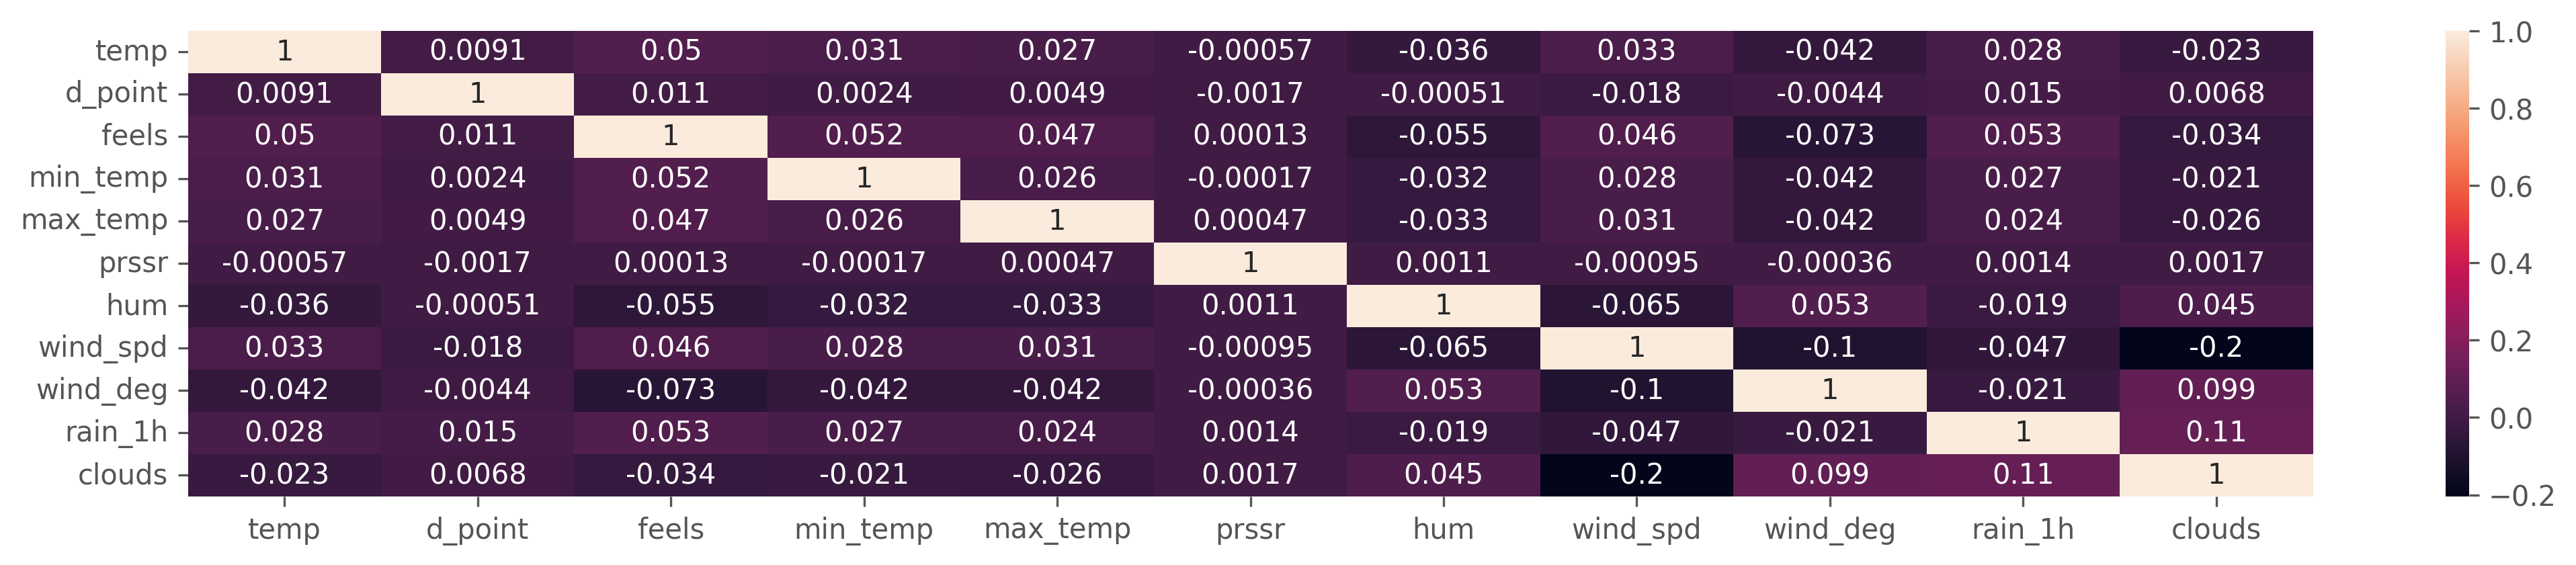

In [228]:
#Menampilkan heatmap korelasi antar variabel
sns.heatmap(df_train.drop(columns=['datetime_iso']).corr(), annot=True)
plt.show()

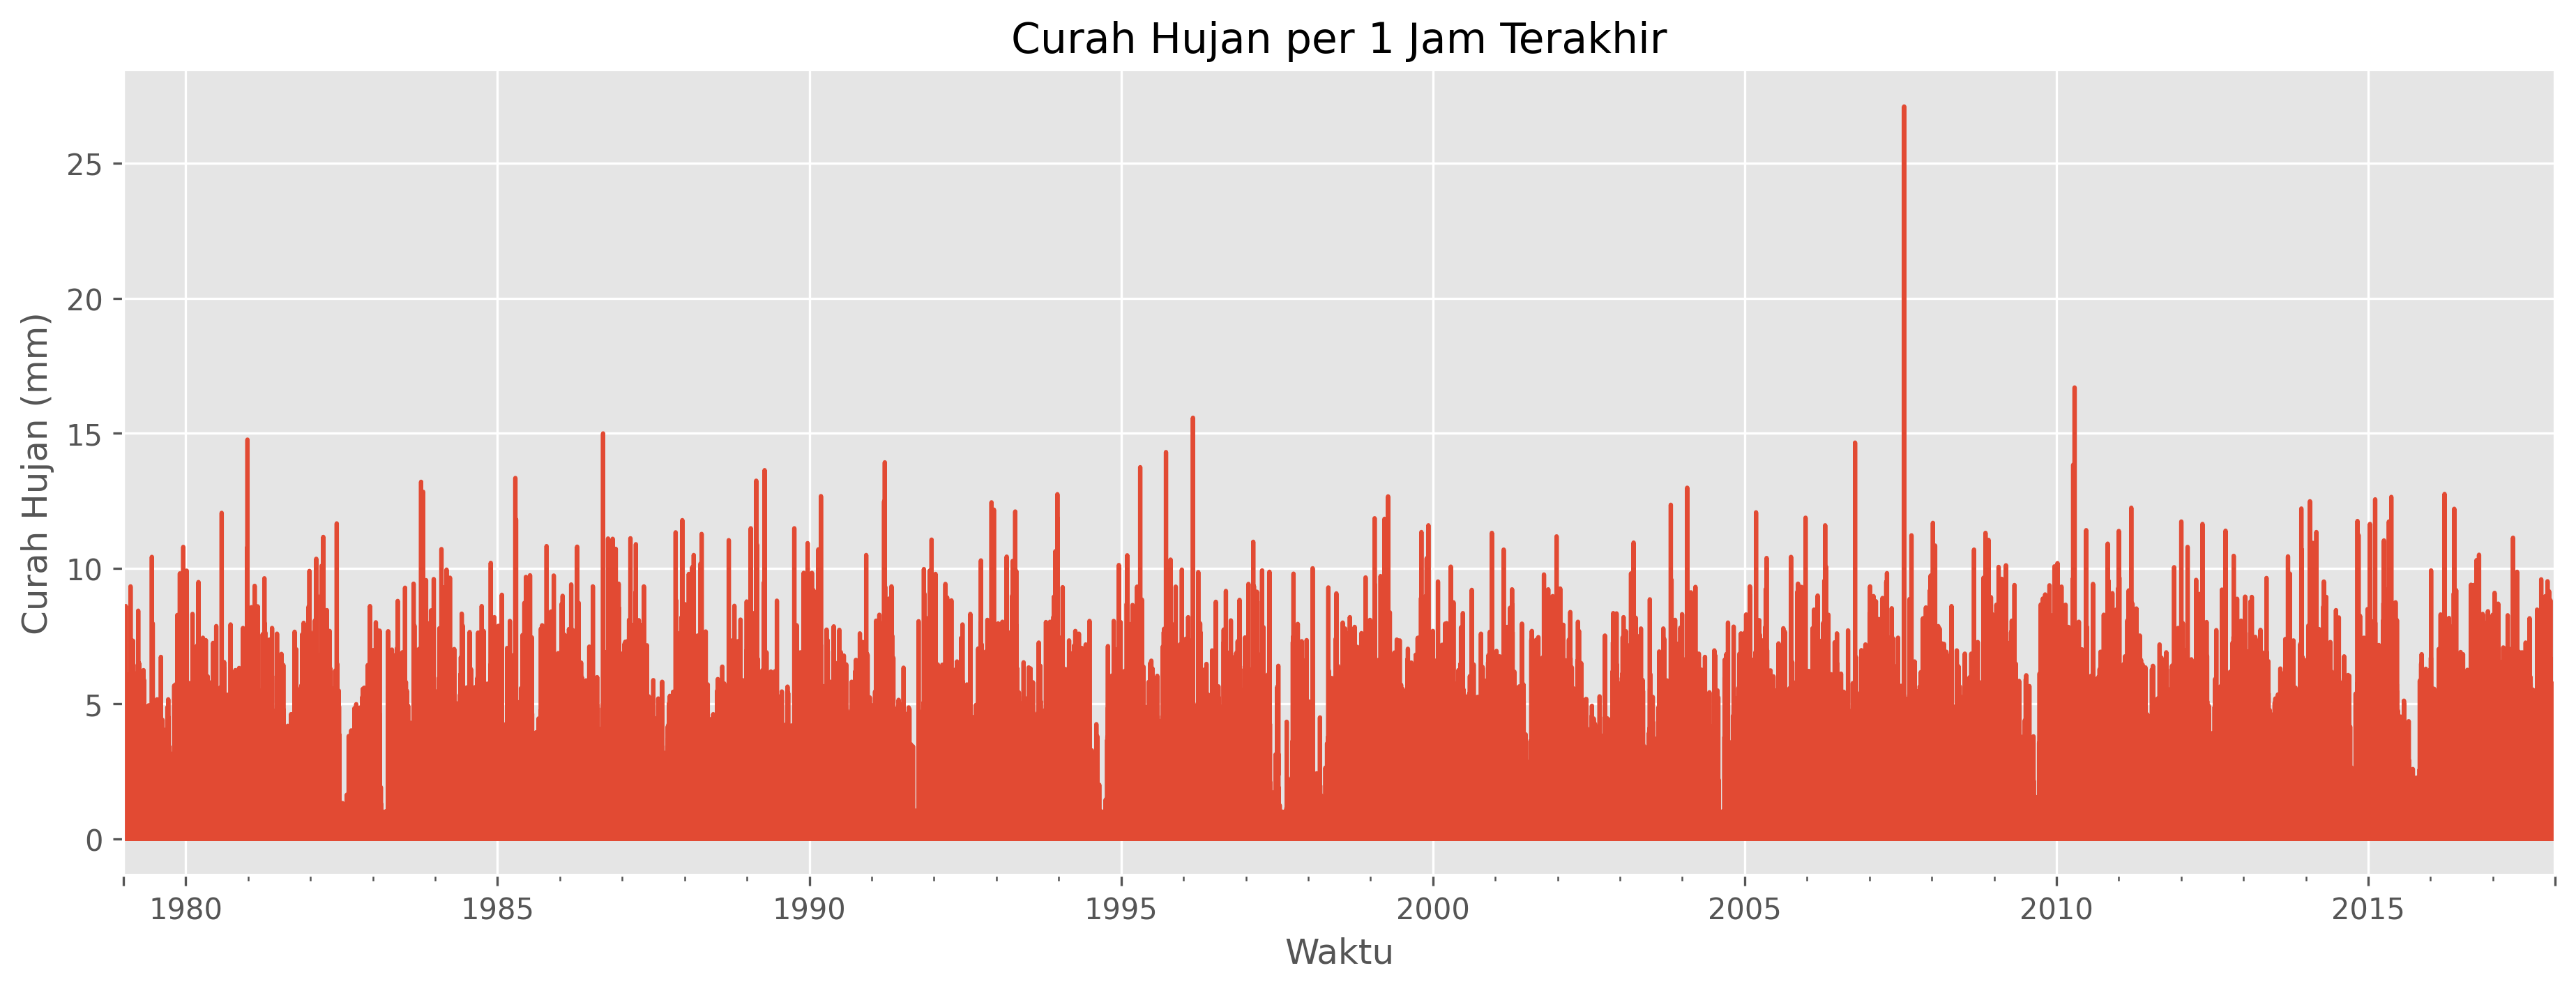

In [230]:
#Mengatur datetime_iso sebagai indeks
df_train = df_train.set_index('datetime_iso')

#Plotting
df_train['rain_1h'].plot(figsize=(15, 5), title='Curah Hujan per 1 Jam Terakhir')

#Menambahkan label sumbu 
plt.xlabel('Waktu')
plt.ylabel('Curah Hujan (mm)')

#Menampilkan plot
plt.show()

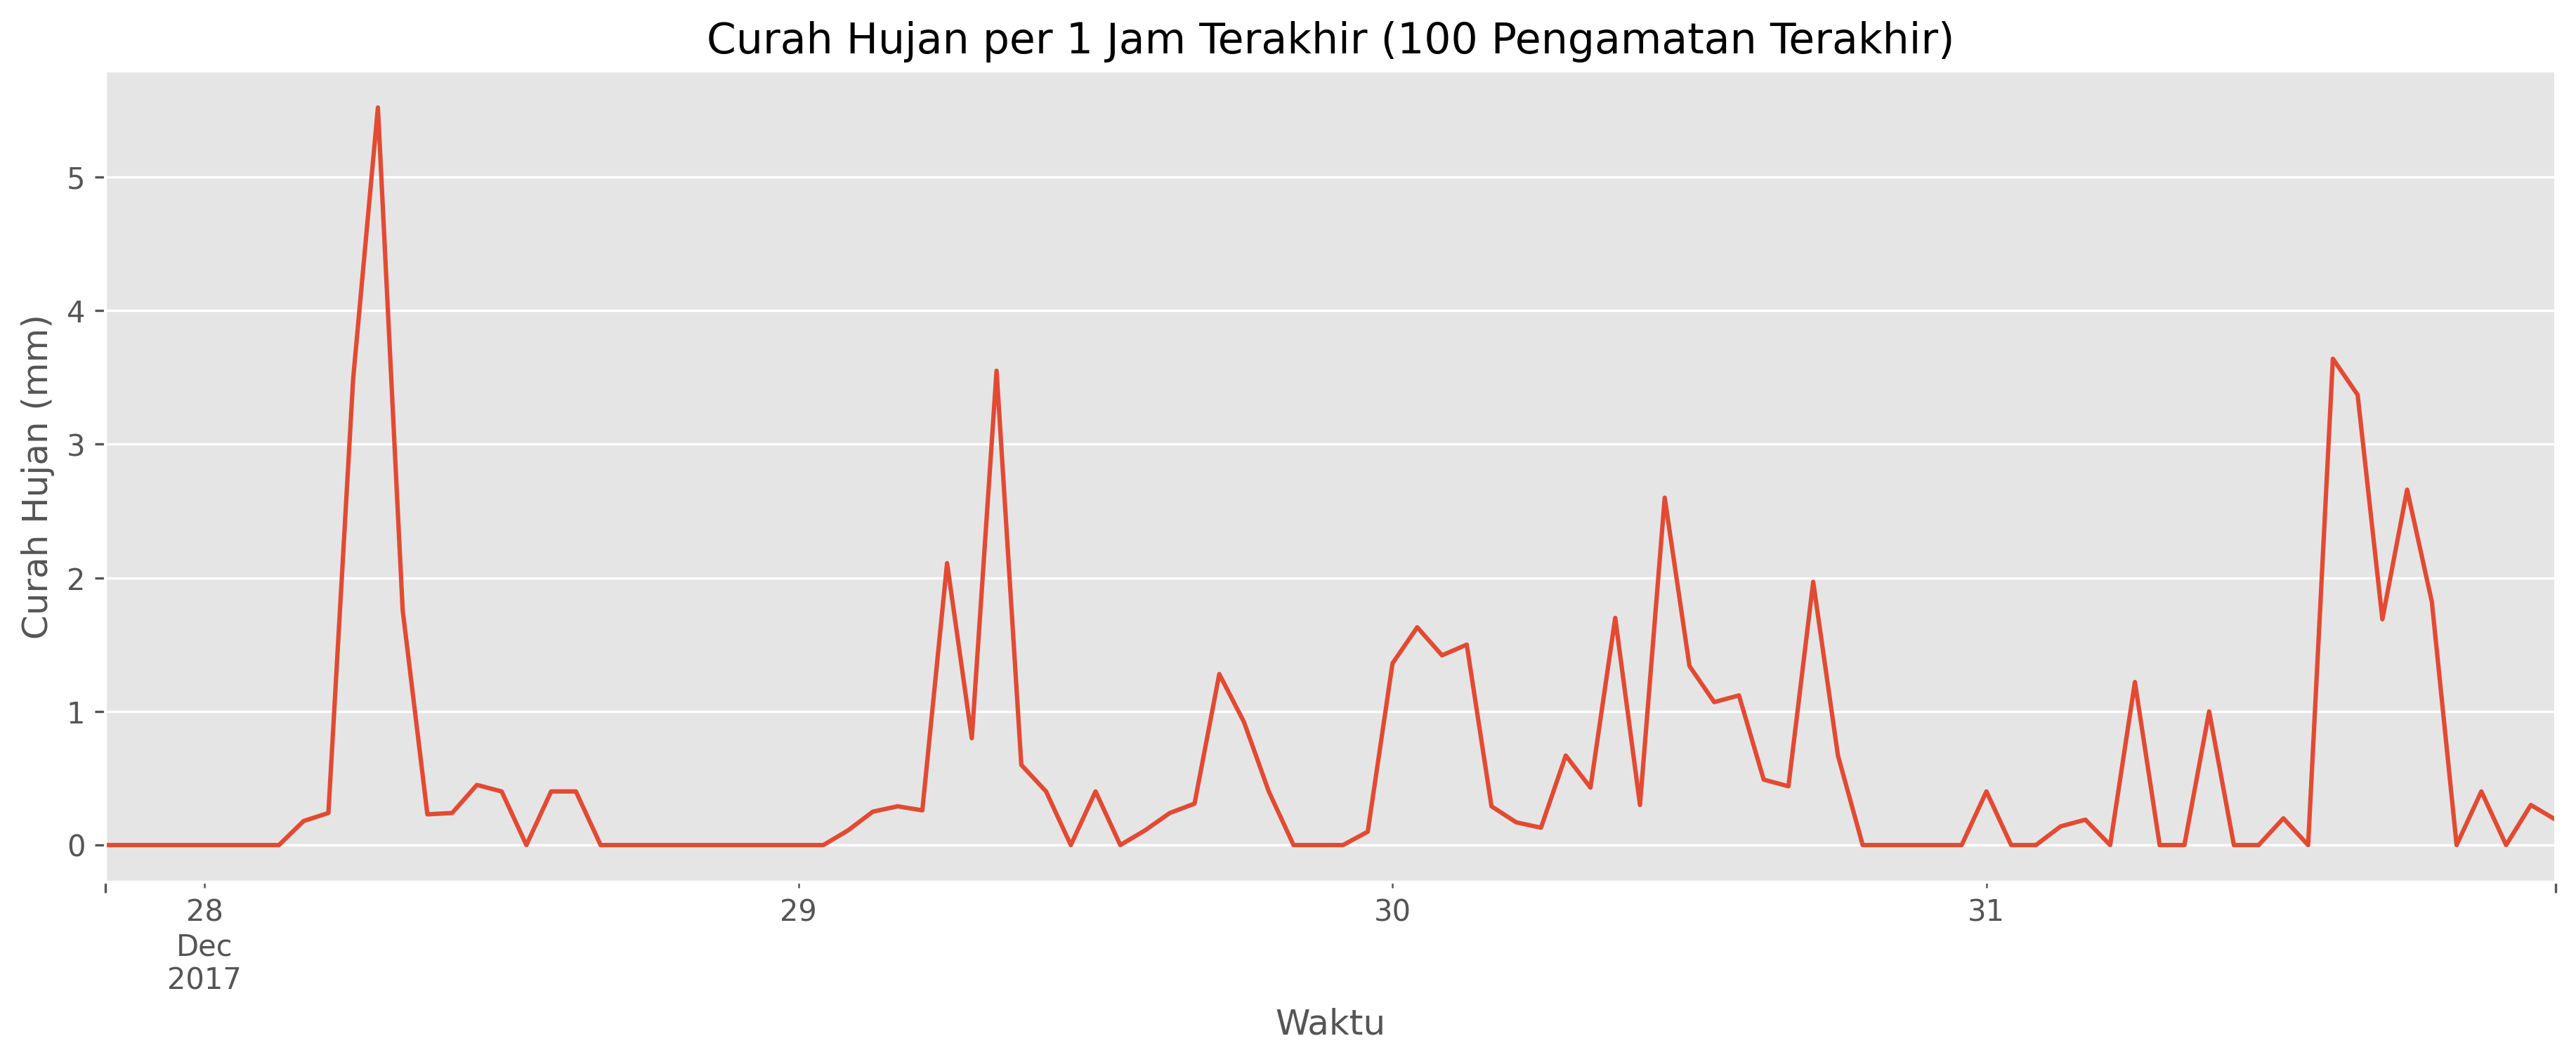

In [231]:
#Plotting
df_train['rain_1h'].tail(100).plot(figsize=(15, 5), title='Curah Hujan per 1 Jam Terakhir (100 Pengamatan Terakhir)')

#Menambahkan label sumbu 
plt.xlabel('Waktu')
plt.ylabel('Curah Hujan (mm)')

#Menampilkan plot
plt.show()

d:\OneDrive\Documents\DATAQUEST\env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\OneDrive\Documents\DATAQUEST\env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\OneDrive\Documents\DATAQUEST\env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


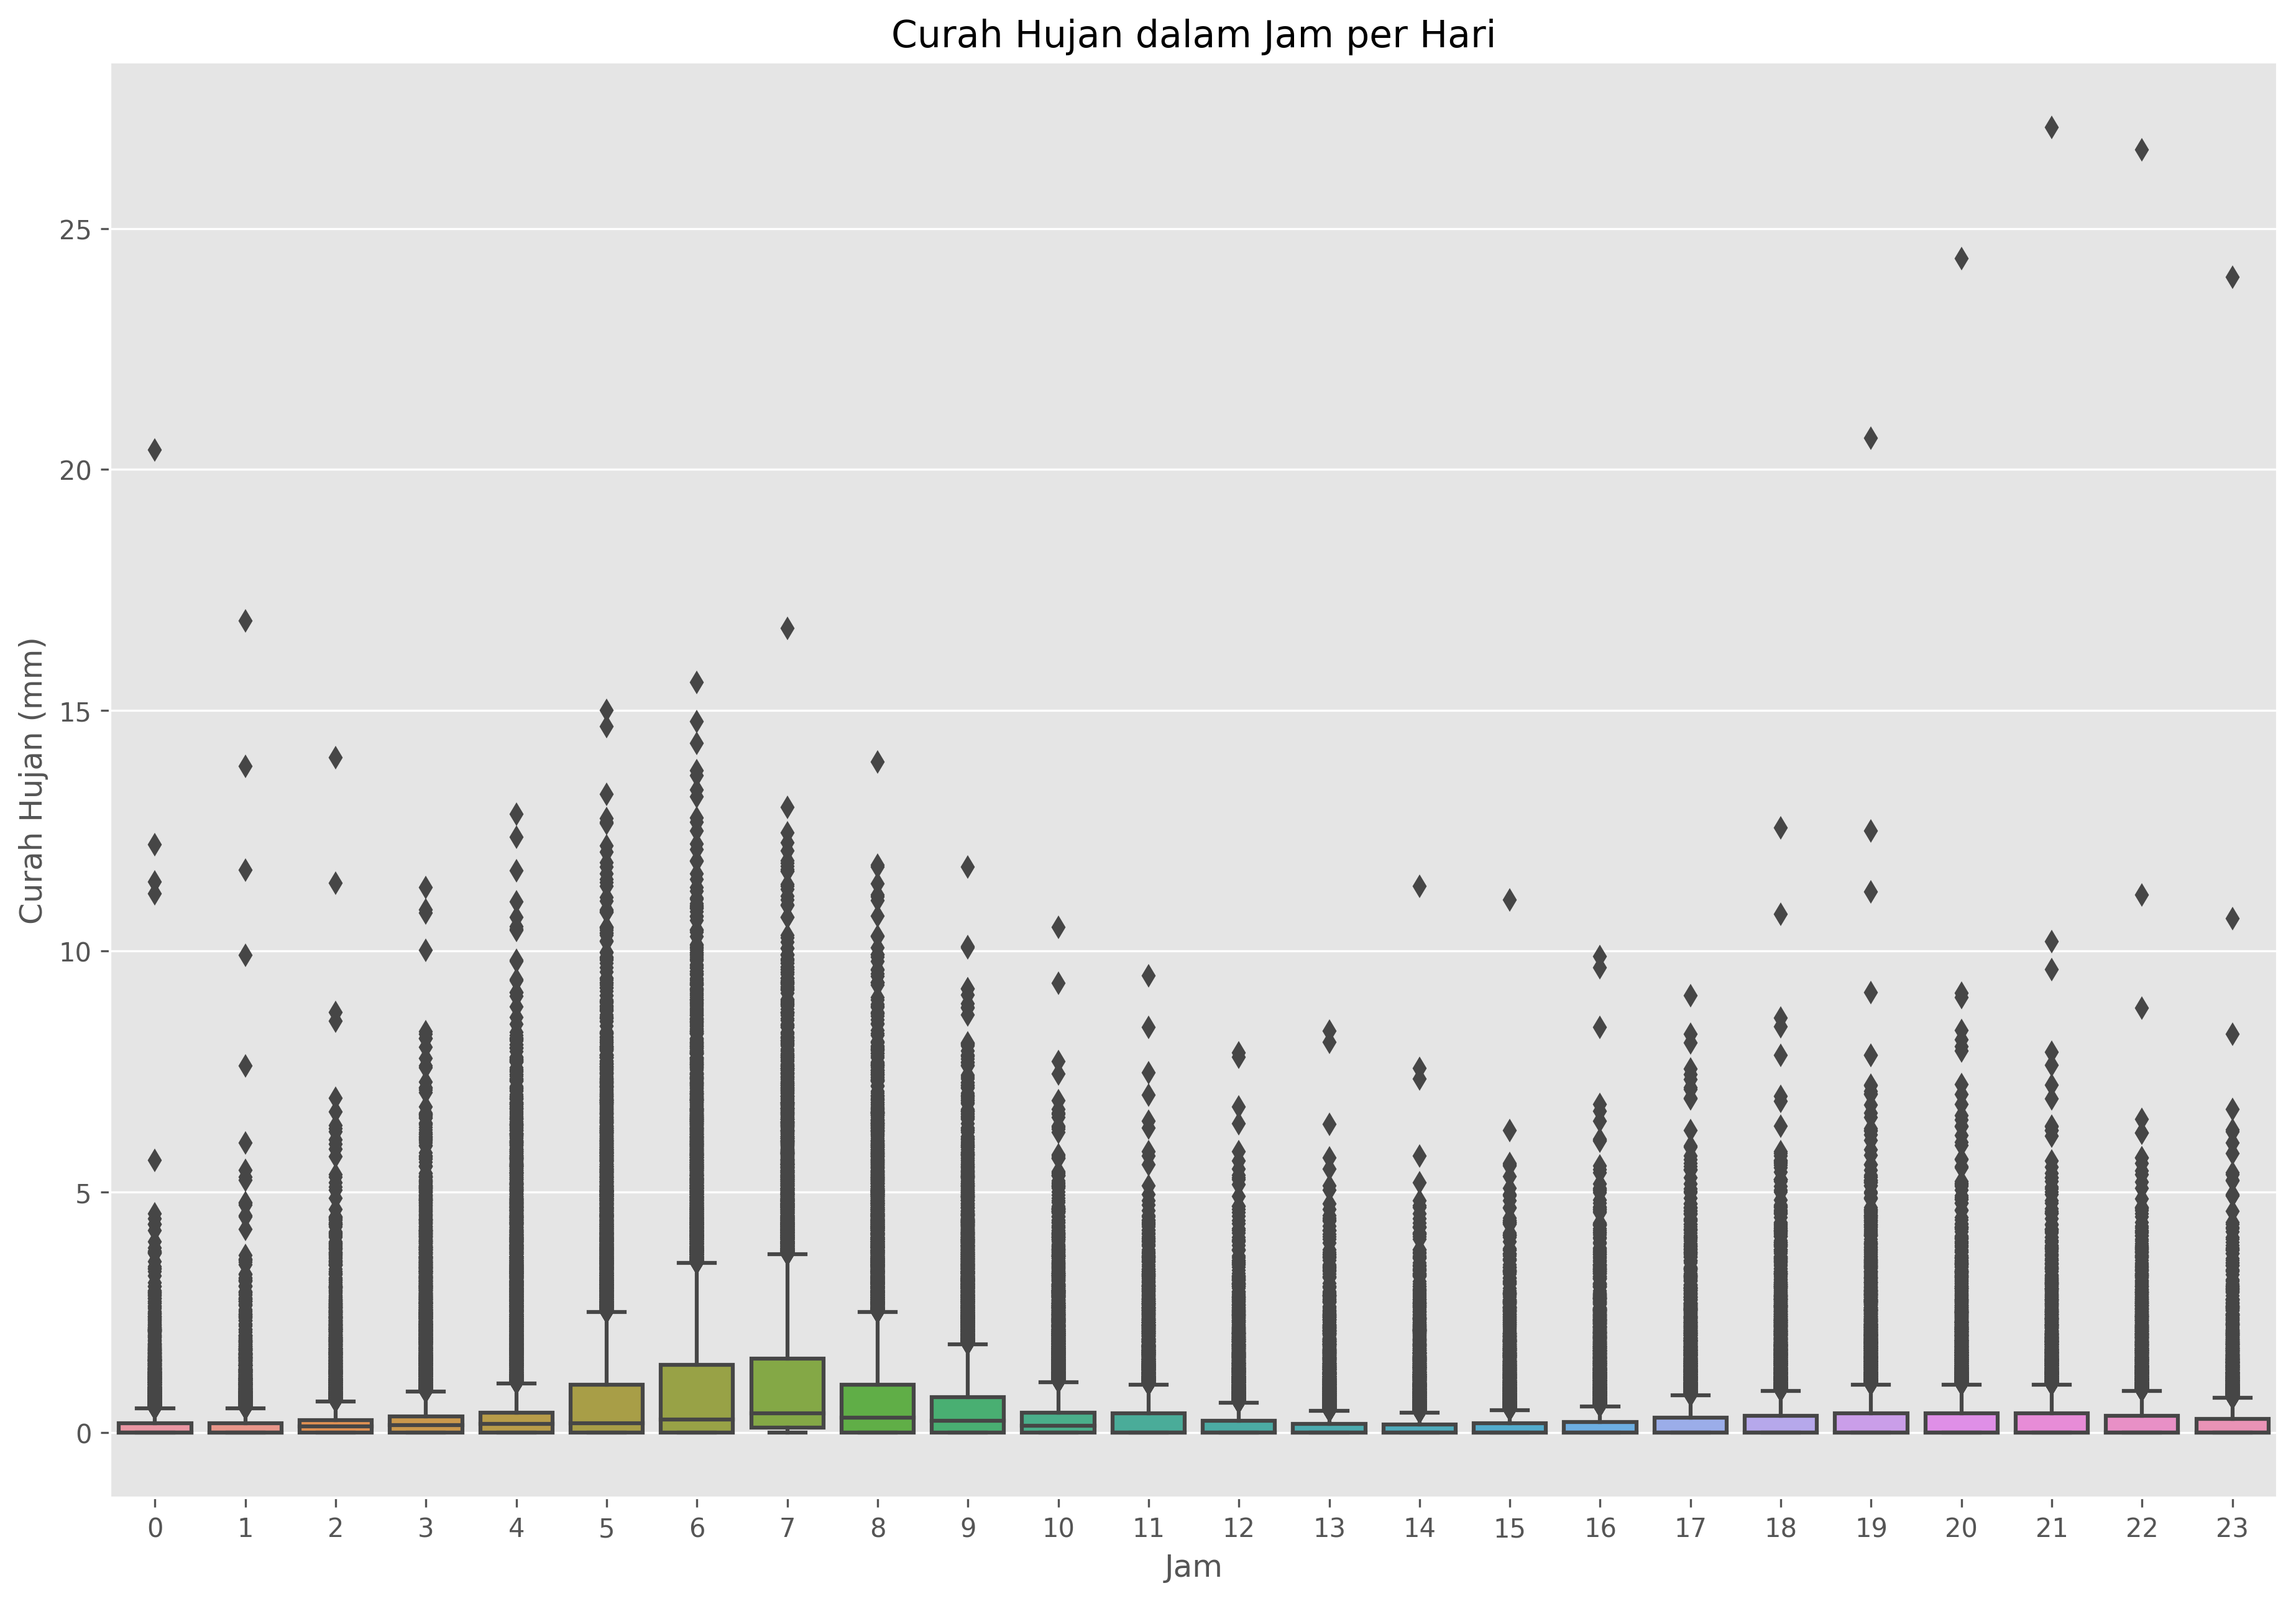

In [232]:
#Menambahkan kolom hour, yaitu index jam per hari (0-23)
df_train['hour']=df_train.index.hour

#Plotting
fig,ax=plt.subplots(figsize=(15,10))
sns.boxplot(data=df_train, x='hour', y='rain_1h')

#Menambahkan label sumbu dan judul
ax.set_title('Curah Hujan dalam Jam per Hari')
plt.xlabel('Jam')
plt.ylabel('Curah Hujan (mm)')

#Menampilkan plot
plt.show()

# Modelling

In [233]:
features = ['temp', 'd_point', 'feels', 'min_temp', 'max_temp', 
            'prssr', 'hum','wind_spd', 'wind_deg', 'clouds']
target = ['rain_1h']

#Mendefinisikan features dan target pada data train
X_train, y_train = df_train[features], df_train[target]

#Mendefinisikan features pada data test
X_test = df_test[features]

In [251]:
#Membentuk model regresi XGBoost
model = xgb.XGBRegressor(n_estimators=6000,
                         learning_rate=0.1,
                         random_state=111)

#Fitting model
model.fit(X_train, y_train,
        eval_set=[(X_train, y_train)],
        eval_metric='rmse',
        verbose=100)

d:\OneDrive\Documents\DATAQUEST\env\Lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
d:\OneDrive\Documents\DATAQUEST\env\Lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
d:\OneDrive\Documents\DATAQUEST\env\Lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
d:\OneDrive\Documents\DATAQUEST\env\Lib\site-packages\xgboost\data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_floa

[0]	validation_0-rmse:0.92991
[100]	validation_0-rmse:0.85617
[200]	validation_0-rmse:0.84464
[300]	validation_0-rmse:0.83518
[400]	validation_0-rmse:0.82456
[500]	validation_0-rmse:0.81424
[600]	validation_0-rmse:0.80707
[700]	validation_0-rmse:0.79718
[800]	validation_0-rmse:0.78875
[900]	validation_0-rmse:0.78107
[1000]	validation_0-rmse:0.77382
[1100]	validation_0-rmse:0.76584
[1200]	validation_0-rmse:0.75916
[1300]	validation_0-rmse:0.75214
[1400]	validation_0-rmse:0.74631
[1500]	validation_0-rmse:0.73938
[1600]	validation_0-rmse:0.73265
[1700]	validation_0-rmse:0.72727
[1800]	validation_0-rmse:0.72190
[1900]	validation_0-rmse:0.71525
[2000]	validation_0-rmse:0.70983
[2100]	validation_0-rmse:0.70394
[2200]	validation_0-rmse:0.69923
[2300]	validation_0-rmse:0.69395
[2400]	validation_0-rmse:0.68873
[2500]	validation_0-rmse:0.68406
[2600]	validation_0-rmse:0.67951
[2700]	validation_0-rmse:0.67397
[2800]	validation_0-rmse:0.66822
[2900]	validation_0-rmse:0.66448
[3000]	validation_0-rm

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=6000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=111, ...)

In [253]:
import pickle
pickle.dump(model, open('model_Datacraft.pkl', 'wb'))

In [254]:
#Membuat kolom prediction pada data train, yaitu hasil prediksi pada data train menggunakan model yang telah dibuat
df_train['prediction'] = model.predict(X_train)

d:\OneDrive\Documents\DATAQUEST\env\Lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
d:\OneDrive\Documents\DATAQUEST\env\Lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
d:\OneDrive\Documents\DATAQUEST\env\Lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
d:\OneDrive\Documents\DATAQUEST\env\Lib\site-packages\xgboost\data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_floa

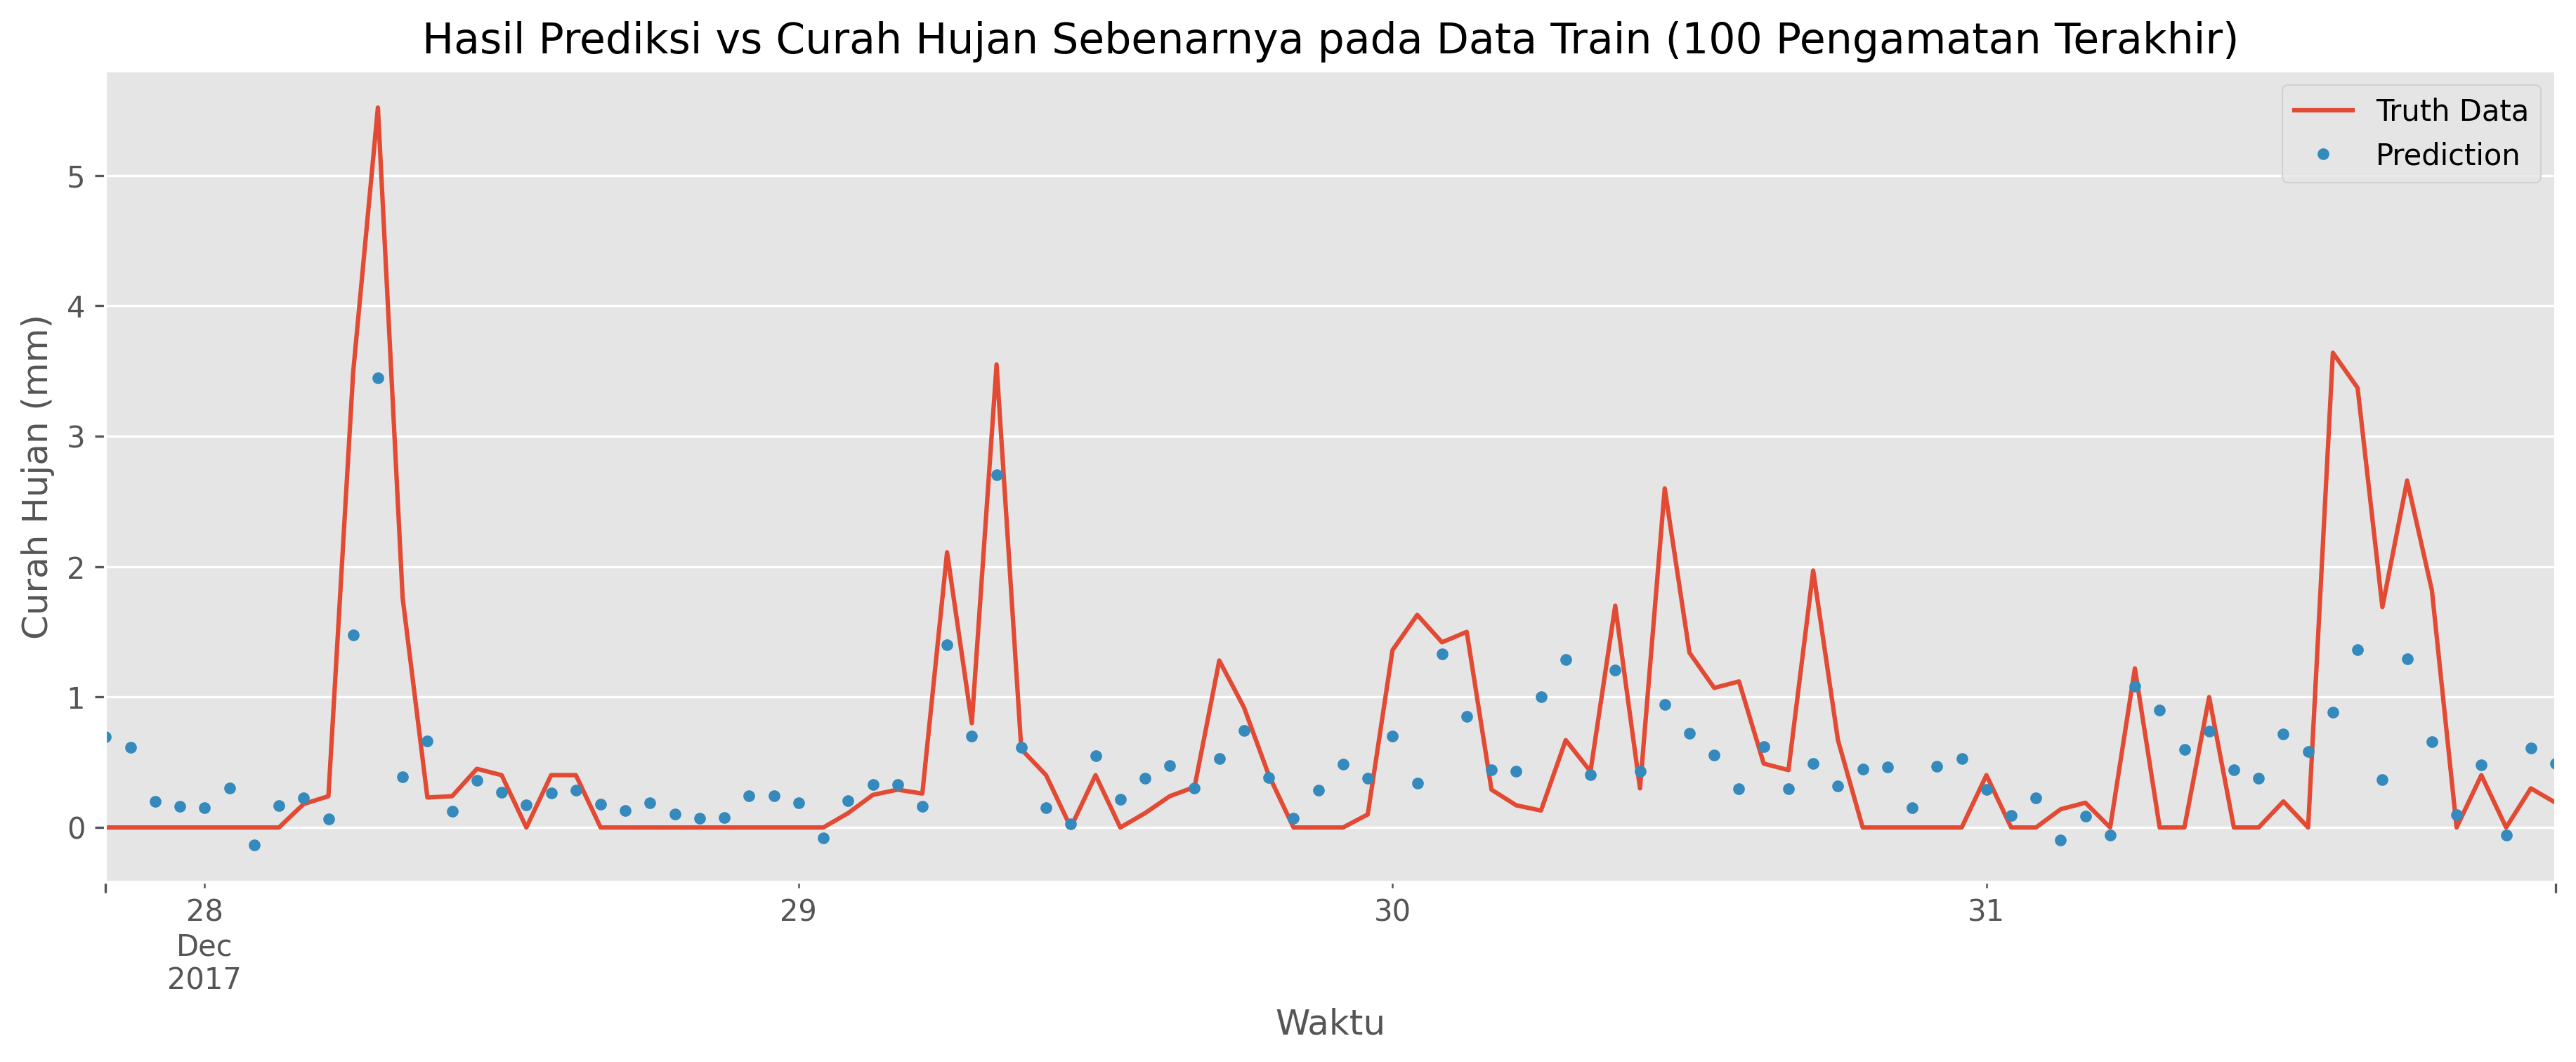

In [255]:
#Membuat plot perbandingan hasil prediksi dan data sebenarnya pada data train
df_train['rain_1h'].tail(100).plot(figsize=(15, 5), title='Hasil Prediksi vs Curah Hujan Sebenarnya pada Data Train (100 Pengamatan Terakhir)')   
df_train['prediction'].tail(100).plot(style='.')

#Menambahkan label sumbu
plt.xlabel('Waktu')
plt.ylabel('Curah Hujan (mm)')

#Menambahkan legenda
plt.legend(['Truth Data','Prediction'])

#Menampilkan plot
plt.show()

In [256]:
#Mencetak skor RMSE akhir dari prediksi model pada data train
score = np.sqrt(mean_squared_error(df_train['rain_1h'], df_train['prediction']))
print(f'Skor RMSE pada Data Train: {score:f}')

Skor RMSE pada Data Train: 0.549513


# Forecast On Test

In [257]:
#Membuat kolom prediction pada data test, yaitu hasil prediksi pada data test menggunakan model yang telah dibuat
df_test['rain_1h'] = model.predict(X_test)
df_test[['rain_1h']].head(10)

d:\OneDrive\Documents\DATAQUEST\env\Lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
d:\OneDrive\Documents\DATAQUEST\env\Lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
d:\OneDrive\Documents\DATAQUEST\env\Lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
d:\OneDrive\Documents\DATAQUEST\env\Lib\site-packages\xgboost\data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_floa

,rain_1h
0,0.318167
1,0.015835
2,1.130790
3,1.292120
4,0.432466
5,2.152643
6,2.044089
7,2.257781
8,1.537708
9,0.362530


In [258]:
#Mengekspor hasil prediksi pada data test
df_test[['datetime_iso','rain_1h']].to_csv('submission1_Datacraft.csv', index=False)  # index=False untuk menghindari penulisan indeks ke dalam file